In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import collections

from pyhive import hive


plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False

In [2]:
begin_time=time.time()

In [ ]:
# 需要传入的参数
year=2018
month=6
first_day=20180601
days=30

In [4]:
# play_log一个月的数据
cursor = hive.connect("localhost",port = 18081).cursor() 
columns=['user_id','client_type','video_id','video_name','playbill_length','server_time']
cursor.execute('select user_id,client_type,video_id,video_name,playbill_length,server_time from cqyx.play_log where day='+str(first_day))
playlog=pd.DataFrame(data=cursor.fetchall())
print 1,playlog.shape
for i in range(2,days+1):
    cursor.execute('select user_id,client_type,video_id,video_name,playbill_length,server_time from cqyx.play_log where day='+str(first_day-1+i))   
    playlog=pd.concat([playlog,pd.DataFrame(data=cursor.fetchall())],axis=0)
    print i,playlog.shape
data=playlog
data.columns=['user_id','client_type','video_id','video_name','playbill_length','server_time']

In [9]:
# nns_buy_order表
cursor = hive.connect("localhost",port = 18081).cursor() 
columns=['nns_user_id','nns_order_price','nns_order_state','nns_modify_time']
cursor.execute('select nns_user_id,nns_order_price,nns_order_state,nns_modify_time from cqyx.nns_buy_order where day='+str(first_day-1+days))
nns_buy_order=pd.DataFrame(data=cursor.fetchall(),columns=columns)

nns_buy_order['nns_modify_time']=nns_buy_order['nns_modify_time']/1000
nns_buy_order=nns_buy_order[nns_buy_order['nns_modify_time']>0]
nns_buy_order['time']=nns_buy_order['nns_modify_time'].apply(timestamp_datetime)
nns_buy_order['time']=pd.to_datetime(nns_buy_order.time)
nns_buy_order['month']=nns_buy_order['time'].dt.month
nns_buy_order['year']=nns_buy_order['time'].dt.year
nns_buy_order=nns_buy_order[nns_buy_order['year']==year][nns_buy_order['month']==month]

In [13]:
# 影片信息表
movie=pd.read_csv('F:\\MyDocuments\\starcor\\20180702\\data\\evs_movie.txt',sep='\\t',encoding='utf-8')
columns=[u'starcor_id',u'evs_director',u'evs_main_actor',u'evs_content_type',u'evs_total_time']
movie=movie[columns]

C:\Users\starcor\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [17]:
data=data.drop_duplicates()

In [18]:
def timestamp_datetime(value):
    value=time.localtime(value)
    return time.strftime('%Y-%m-%d %H:%M:%S',value)

In [19]:
data['server_time_1']=data['server_time']/1000
data['day']=data['server_time_1'].apply(timestamp_datetime)
data['day']=pd.to_datetime(data.day)
data['day']=data['day'].dt.day

In [20]:
data1=data.groupby(by=['user_id','client_type','video_id','video_name','day'],as_index=False)['server_time'].agg({'server_time_max':max,'server_time_min':min})
data1['playbill_length']=(data1.server_time_max-data1.server_time_min)/60000
data1.drop('server_time_max',axis=1,inplace=True)

In [22]:
def time_stage(value):
    if (value >=0 and value<=6):
        return '凌晨'
    elif (value>6 and value<=12):
        return '上午'
    elif (value>12 and value<=16):
        return '下午'
    else:
        return '夜晚'

In [23]:
data1['server_time_min']=data1['server_time_min']/1000
data1['time']=data1['server_time_min'].apply(timestamp_datetime)
data1['time']=pd.to_datetime(data1.time)
data1['hour']=data1['time'].dt.hour
data1['day_stage']=data1['hour'].apply(time_stage)
data1=data1.drop(['time'],axis=1)

In [25]:
# 关联影片信息表
data2=pd.merge(data1,movie,left_on='video_id',right_on='starcor_id')
data2['watch_time']=data2['playbill_length']/data2['evs_total_time']

#### 点击量最多影片top20 

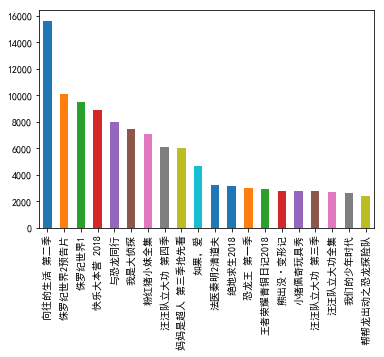

In [26]:
data1['video_name'].value_counts().head(20).plot(kind='bar')

#### 影片点击量分布图

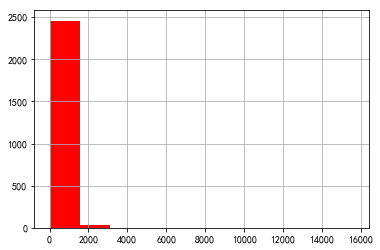

In [27]:
data1['video_name'].value_counts().hist(color='red')

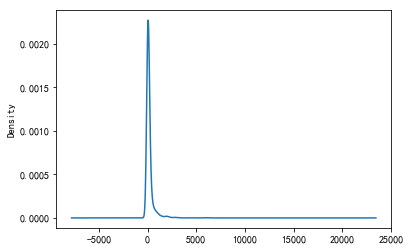

In [28]:
data1['video_name'].value_counts().plot.kde()

#### 影片类型按点击量top20

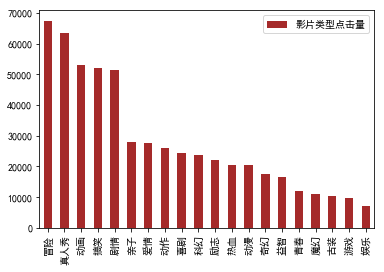

In [29]:
list1=[]
for i in data2.evs_content_type.tolist():
    a=str(i).split('/')
    for j in a:
        list1.append(j)
df=pd.DataFrame.from_dict(dict(collections.Counter(list1)),orient='index').sort_values(by=0,ascending=False)
df.columns=[u'影片类型点击量']
df.head(20).plot.bar(color='brown')

#### 影片类型按点击量分布图

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000A7E5358>]],
      dtype=object)

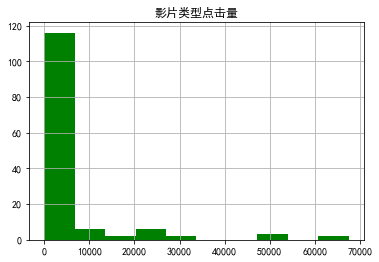

In [30]:
df.hist(color='green')

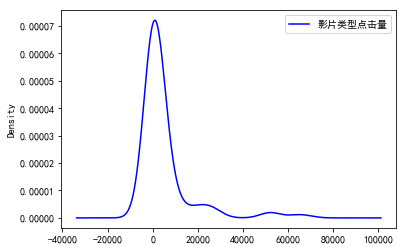

In [31]:
df.plot.kde(color='blue')

#### 播放时长最多影片top20

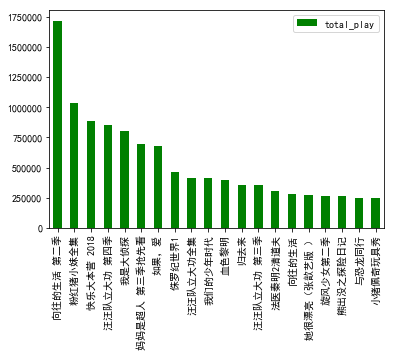

In [32]:
df=data1.groupby('video_name',as_index=False)['playbill_length'].agg({'total_play':sum}).sort_values(by='total_play',ascending=False)
df.index=df.video_name.tolist()
df.head(20).plot(kind='bar',color='green')

#### 播放时长最短影片top20

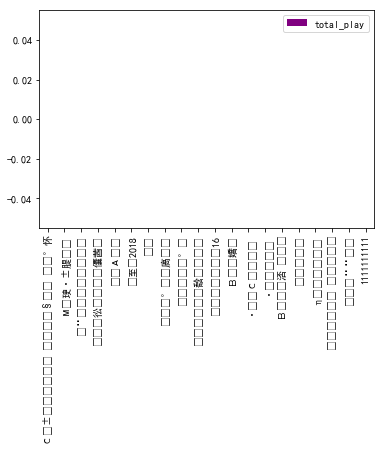

In [33]:
df.tail(20).plot(kind='bar',color='purple')

#### 影片播放时长分布图

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B14D898>]],
      dtype=object)

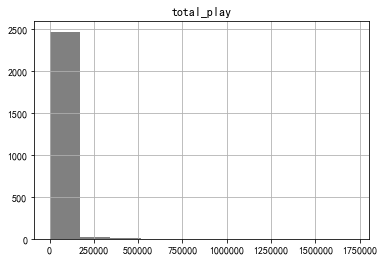

In [34]:
df.hist(color='grey')

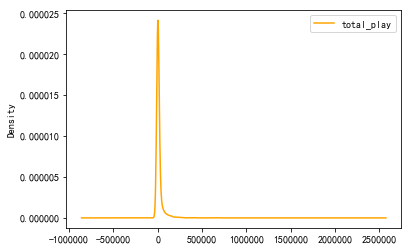

In [35]:
df.plot.kde(color='orange')

#### 时长播放比例最多影片top20

C:\Users\starcor\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


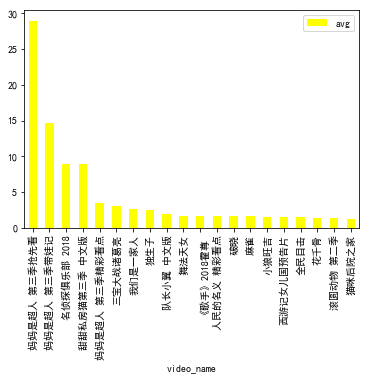

In [36]:
df=data2.groupby('video_name')['watch_time'].agg({'avg':'mean'}).sort_values(by='avg',ascending=False)
df=df.replace([np.inf, -np.inf], np.nan).dropna(subset=['avg'], how="all")
df.head(20).plot.bar(color='yellow')

#### 时长播放比例最少影片top20

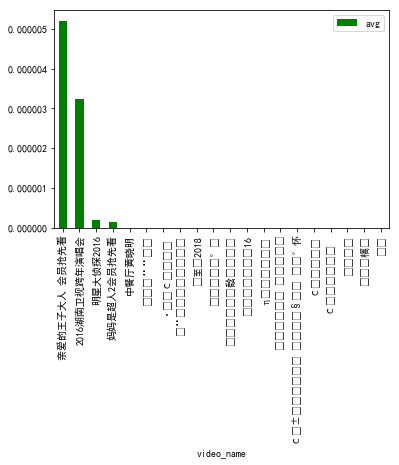

In [37]:
df.tail(20).plot.bar(color='green')

#### 影片播放时长比例分布图

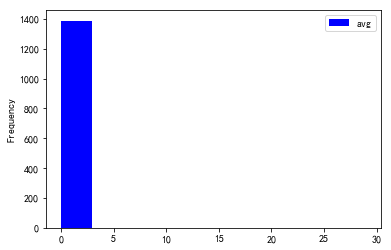

In [38]:
df.plot.hist(color='blue')

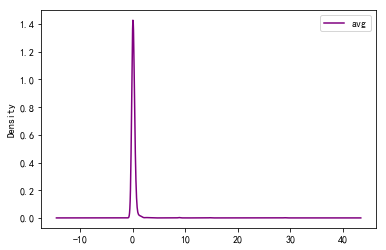

In [39]:
df.plot.kde(color='purple')

#### 点击最多演员top20

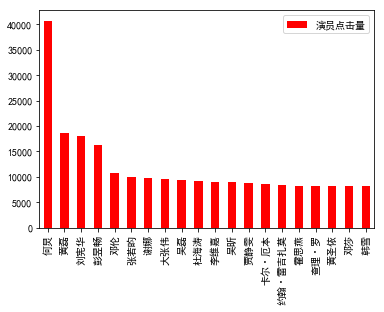

In [40]:
list1=[]
for i in data2.evs_main_actor.tolist():
    a=str(i).split('/')
    for j in a:
        list1.append(j)
df=pd.DataFrame.from_dict(dict(collections.Counter(list1)),orient='index').sort_values(by=0,ascending=False)
df=df.drop(['未知','0',''],axis=0)
df.columns=[u'演员点击量']
df.head(20).plot.bar(color='red')

#### 演员按点击量分布图

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BE84E80>]],
      dtype=object)

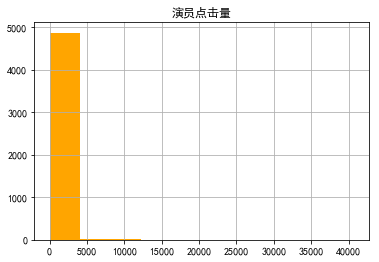

In [41]:
df.hist(color='orange')

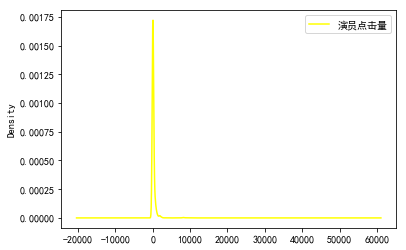

In [42]:
df.plot.kde(color='yellow')

#### 播放时长最多演员top20

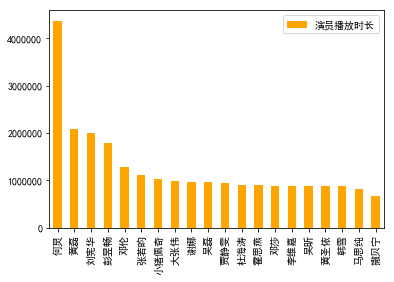

In [43]:
dict1={}
for i in range(data2.shape[0]):
    a=str(data2.loc[i,'evs_main_actor']).split('/')
    for j in a:
        if dict1.has_key(j):
            dict1[j]=dict1[j]+data2.loc[i,'playbill_length']
        else:
            dict1[j]=0
df=pd.DataFrame.from_dict(dict1,orient='index').sort_values(by=0,ascending=False)
df=df.drop(['未知','0',''])
df.columns=[u'演员播放时长']
df.head(20).plot.bar(color='orange')

#### 演员播放时长分布图

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000BDCE58D0>]],
      dtype=object)

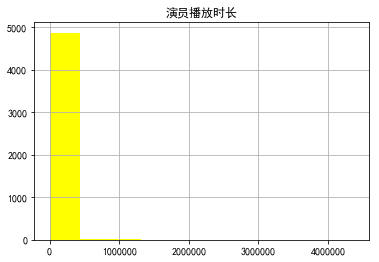

In [44]:
df.hist(color='yellow')

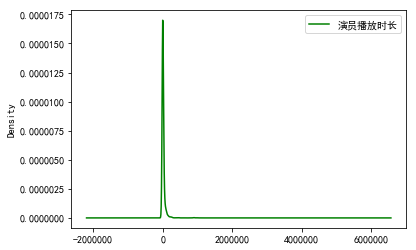

In [45]:
df.plot.kde(color='green')

#### 点击最多导演top20

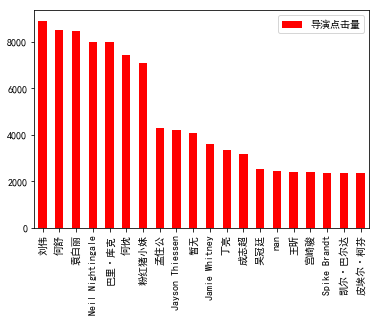

In [46]:
list1=[]
for i in data2.evs_director.tolist():
    a=str(i).split('/')
    for j in a:
        list1.append(j)
df=pd.DataFrame.from_dict(dict(collections.Counter(list1)),orient='index').sort_values(by=0,ascending=False)
df=df.drop(['未知','0',''],axis=0)
df.columns=[u'导演点击量']
df.head(20).plot.bar(color='red')

#### 导演点击量分布图

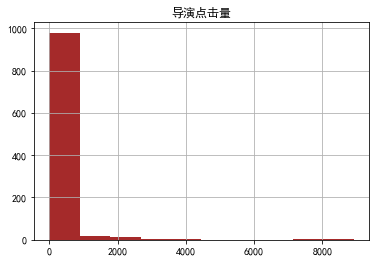

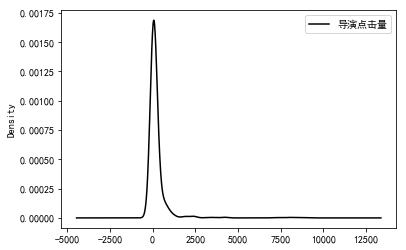

In [47]:
df.hist(color='brown')
df.plot.kde(color='black')

#### 播放时长最多导演top20

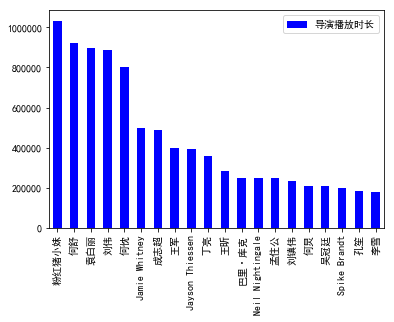

In [48]:
dict1={}
for i in range(data2.shape[0]):
    a=str(data2.loc[i,'evs_director']).split('/')
    for j in a:
        if dict1.has_key(j):
            dict1[j]=dict1[j]+data2.loc[i,'playbill_length']
        else:
            dict1[j]=0
df=pd.DataFrame.from_dict(dict1,orient='index').sort_values(by=0,ascending=False)
df.columns=[u'导演播放时长']
df=df.drop(['未知','0','','暂无'])
df.head(20).plot.bar(color='blue')

#### 导演按播放时长分布图

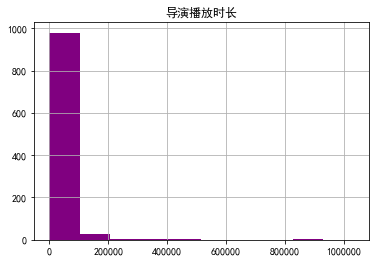

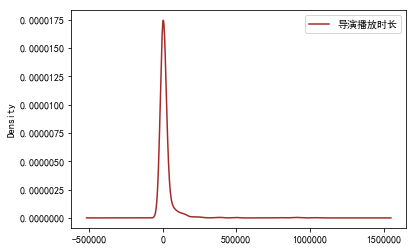

In [49]:
df.hist(color='purple')
df.plot.kde(color='brown')

#### 用户按播放次数分布图

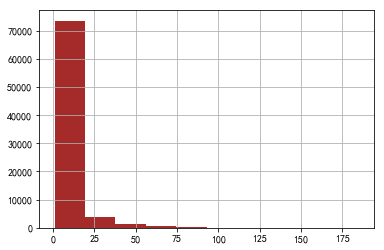

In [50]:
data1.user_id.value_counts().hist(color='brown')

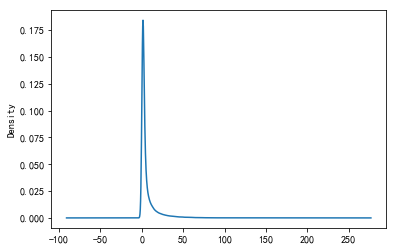

In [51]:
data1.user_id.value_counts().plot.kde()

#### 用户按播放时长分布图

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000110BACC0>]],
      dtype=object)

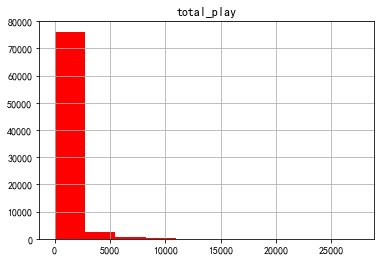

In [52]:
data1.groupby('user_id',as_index=False)['playbill_length'].agg({'total_play':sum}).hist(color='red')

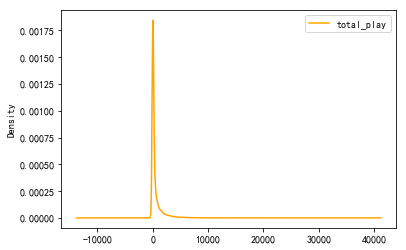

In [53]:
data1.groupby('user_id',as_index=False)['playbill_length'].agg({'total_play':sum}).plot.kde(color='orange')

#### 用户按播放时间（凌晨、早、中、晚等等）分布图

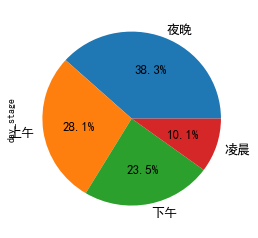

In [54]:
data1[['user_id','day_stage']].drop_duplicates().day_stage.value_counts().plot.pie(autopct='%1.1f%%', fontsize=13,figsize=(4,4))

#### 用户影片间切换时间分布图

In [55]:
df=data1.copy()
df = df.sort_values(['user_id', 'server_time_min']) # 先按照uid和time排一下序
df['pre'] = df['server_time_min'].shift(1)
df['uid'] = df['user_id'].shift(1)
df['interval'] = (df['server_time_min'] - df['pre'])
df1 = df[(df['user_id'] == df['uid'])]
df1=df1[['user_id','server_time_min','interval']]
df1['interval']=df1['interval']/100

C:\Users\starcor\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000011457E48>]],
      dtype=object)

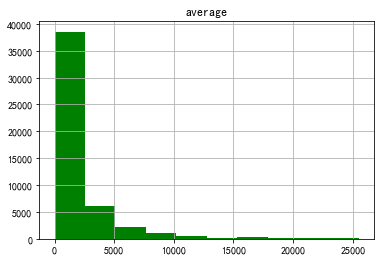

In [56]:
df1.groupby('user_id')['interval'].agg({'average':'mean'}).hist(color='green')

C:\Users\starcor\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


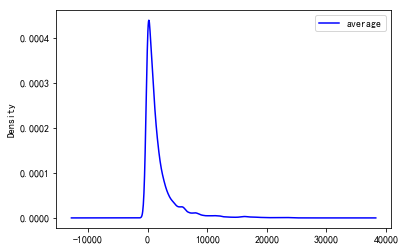

In [57]:
df1.groupby('user_id')['interval'].agg({'average':'mean'}).plot.kde(color='blue')

#### 最快切换影片时间用户top20

C:\Users\starcor\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


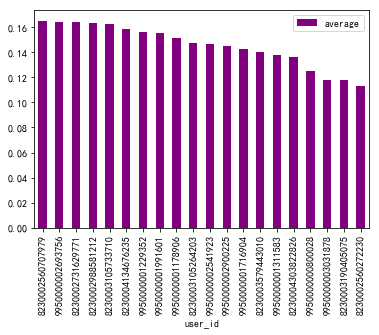

In [58]:
df1.groupby('user_id')['interval'].agg({'average':'mean'}).sort_values(by='average',ascending=False).tail(20).plot.bar(color='purple')

#### 最慢切换影片时间用户top20

C:\Users\starcor\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


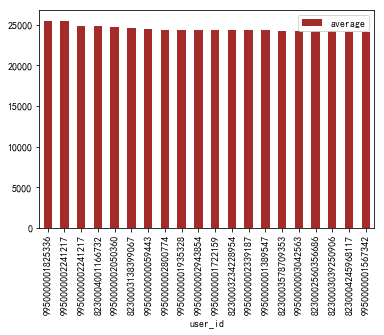

In [59]:
df1.groupby('user_id')['interval'].agg({'average':'mean'}).sort_values(by='average',ascending=False).head(20).plot.bar(color='brown')

#### 订购金额用户分布图

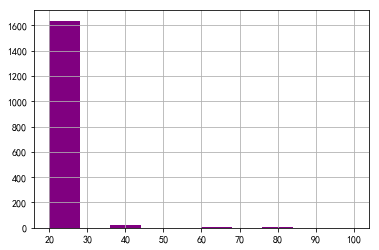

In [60]:
nns_buy_order=nns_buy_order[nns_buy_order.nns_order_state==1]
nns_buy_order.groupby('nns_user_id',as_index=False)['nns_order_price'].agg({'individual':sum})['individual'].hist(color='purple')

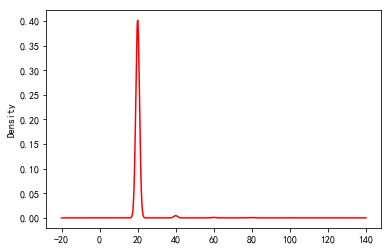

In [61]:
nns_buy_order.groupby('nns_user_id',as_index=False)['nns_order_price'].agg({'individual':sum})['individual'].plot.kde(color='red')

#### 最大订购金额用户top20

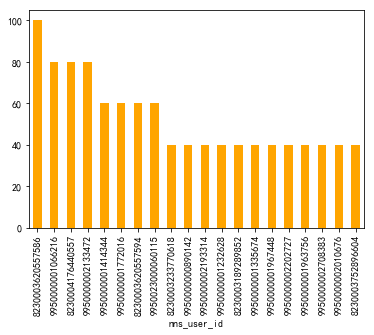

In [62]:
df=nns_buy_order.groupby('nns_user_id',as_index=False)['nns_order_price'].agg({'individual':sum}).sort_values(by='individual',ascending=False).head(20)
df.index=df.nns_user_id
df['individual'].plot(kind='bar',color='orange')

#### 终端使用用户数分布图

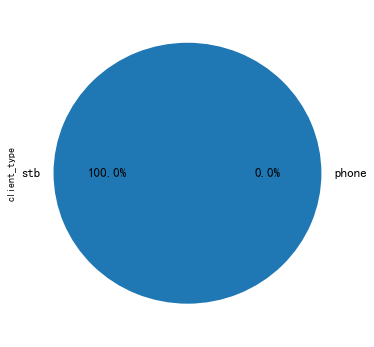

In [63]:
data1[['user_id','client_type']].drop_duplicates().client_type.value_counts().plot.pie(autopct='%1.1f%%', fontsize=13,figsize=(6,6))

#### 终端使用播放时长分布图

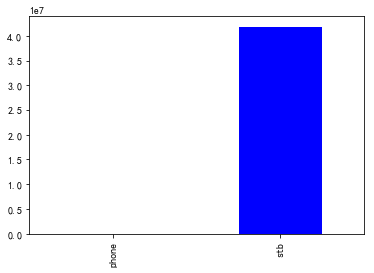

In [64]:
df=data1.groupby('client_type',as_index=False)['playbill_length'].agg({'total_play':sum})
df.index=df.client_type.tolist()
df.total_play.plot(kind='bar',color='blue')

#### 终端使用时段分布图

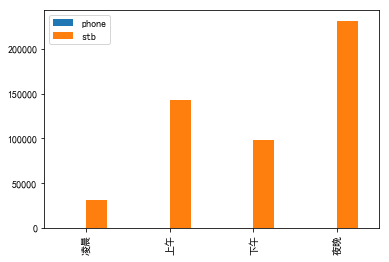

In [68]:
temp1=data1['day_stage'][data1['client_type']=='stb'].value_counts().sort_values(ascending=True)
temp2=data1['day_stage'][data1['client_type']=='phone'].value_counts()
temp=pd.DataFrame({'stb':temp1,'phone':temp2})

temp_a=temp.iloc[0:2,:]
temp_b=pd.DataFrame(temp.iloc[2,:]).T
temp_c=pd.DataFrame(temp.iloc[3,:]).T
temp=pd.concat([temp_b,temp_a],axis=0)
temp=pd.concat([temp,temp_c],axis=0)

temp.plot(kind='bar',stacked=False)

In [66]:
print 'Total Time:',(time.time()-begin_time)

Total Time: 159.345000029


In [67]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')